In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as soup, SoupStrainer
import requests
import lxml
from collections import Counter
from requests import exceptions
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import steam
import pandas as pd
import numpy as np
from rake_nltk import Rake
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from steam.api import interface
steam.api.key.set('FC864146AEF094845C669F86F0B20CFF')
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 80)
%matplotlib inline

# Steam Recommendation Engine #
## Overview ##
As someone somewhere probably said, it's the best time to be playing video games.  Democratization of the tools needed and technical know-how has gotten to the point that almost anyone can sit down and within a matter of 80-100 work weeks over 2-4 years (lol) crank out a game.  But with this over-abundance of choice comes a new problem... UNCERTAINTY. "Do I buy that hot new game that just came out?  What about that other new hot game that came out or that older game that everyone said was great?  Hell, maybe I should just play one of the games I already bought but never installed?”  My aim is to build a recommendation engine that will help people (ME) with this.  Specifically, the engine will not just recommend games available on steam, but will also recommend you games that are already in your library but unplayed.  Yay for saving money!

## Data Collection ##
In order to build the recommendation engine using steam, I used BeautifulSoup to crawl the Steam Store for all games with steam pages. I did this in two steps.  Step 1 was generating a list of links to each game's steam page, starting at page 1 (https://store.steampowered.com/search/?category1=998&page=1).  Once I was able to grab every link, I iterated through each one, grabbing relevant fields such as title, image, description, tags, reviews, etc.

### Grabbing each store link ###

In [ ]:
# Get title and links for all steam games
#urls = ['https://store.steampowered.com/search/?category1=998&page={}'.format(i) for i in range(1, 1185)]

filename = "products_v2.csv"
f = open(filename, "w", encoding="utf-8")
headers = "game_title\tsteam_url\n"
f.write(headers)

for url in urls:
    r = requests.get(url)
    page_soup = soup(r.content, "html.parser")

    containers = page_soup.findAll("a", {"class":"search_result_row ds_collapse_flag "})

    for container in containers:
        game_title = container.findAll("span", {"class":"title"})[0].text
        link = container["href"]

        #print(game_title)
        #print(link)
        #print("----------------")

        f.write(game_title + "\t" + link + "\n")

f.close()

### Iterating through each link, grabing all relevant info from the page###

In [ ]:
#df_links = pd.read_csv('products_v2.csv', delimiter="\t")

tags = []
images = []
descriptions = []
num_reviews = []
rating_values = []
releases = []

cookies = {'birthtime': '568022401'}

for link in df_links.iterrows():
    print(link[1]['game_title'])
    url = link[1]['steam_url']
    r = requests.get(url, cookies=cookies)
    page_soup = soup(r.content, 'lxml')
    try:
        tag = page_soup.find("div", {"class":"glance_tags popular_tags"})
        tag = tag.text
        tag = tag.replace('\t', '').replace('\r', '').replace('\n', ', ').replace('+, ', '').replace(', , ', '')
        tags.append(tag)
    except:
        tag = 'no tags'
        tags.append(tag)
    
    try:
        image = page_soup.find('img', {'class':'game_header_image_full'})['src']
        images.append(image)
    except:
        image = 'no_image'
        images.append(image)
    
    try:
        num_review = int(page_soup.find('meta', {'itemprop':'reviewCount'})['content'])
        num_reviews.append(num_review)
    except:
        num_review = 'no reviews'
        num_reviews.append(num_review)

    try:
        rating_value = float(page_soup.find('meta', {'itemprop':'ratingValue'})['content'])
        rating_values.append(rating_value)
    except:
        rating_value = 'no rating'
        rating_values.append(rating_value)
    
    try:
        description = page_soup.find('div', {'class': 'game_description_snippet'}).text.replace('\t','').replace('\r','').replace('\n', '')
        descriptions.append(description)
    except:
        description = 'no description'
        descriptions.append(description)
        
    try:
        release = page_soup.find('div', {'class': 'date'}).text
        releases.append(release)
    except:
        release = 'no release date'
        releases.append(release)

        
        
    
      
the_rest = pd.DataFrame({'tags': tags, 'image': images, 'description': descriptions,
                         'number_of_review': num_reviews,
                         'score': rating_values,
                         'release_date': releases})

steam_scrape_the_rest = pd.concat([df_links, the_rest], axis=1, sort=False)
steam_scrape_the_rest.to_csv('steam_games_all_fields.csv', sep='\t')

## Data Cleaning and Processing ##

In [10]:
steam_games = pd.read_csv('steam_games_all_fields.csv', index_col=0, delimiter='\t')

# Split out 'appid' from the URL string.  This will be used later to merge in my own games
# from the steam api
app_id = steam_games['steam_url'].str.split('/',expand=True)
app_id = app_id.drop([0, 1, 2, 5, 6], axis=1)
app_id.columns = ['app', 'game_ID']
df = pd.concat([steam_games, app_id], axis=1, sort=False)

# Fill nil values and remove random characters
df['description'] = df['description'].fillna('')
df = df[~df.description.str.contains('no description')]
df['release_date'] = df['release_date'].replace({'no release date' : ''})
df['game_title'] = df['game_title'].str.replace(r'®', '')
df['game_title'] = df['game_title'].str.replace(r'™', '')
df['number_of_review'] = df['number_of_review'].replace({'no reviews' : ''})
df['score'] = df['score'].replace({'no rating' : ''})

df = df.drop(['app'], axis=1)
df['game_ID'] = pd.to_numeric(df['game_ID'], downcast='signed')
df['number_of_review'] = pd.to_numeric(df['number_of_review'], downcast='integer')
df['score'] = pd.to_numeric(df['score'])
#df = df[df['number_of_review'] > 0]
df = df.rename(columns={"game_ID": "appid"})
df = df.rename(columns={"Unnamed: 0": "id"})
df = df.drop_duplicates(subset='appid', keep='first')
df = df.dropna(subset=['game_title'])
df = df.reset_index()
df = df.drop(['index'], axis=1)
df.shape

(23601, 9)

There are 4,837,149 words in the combination of all descriptions.


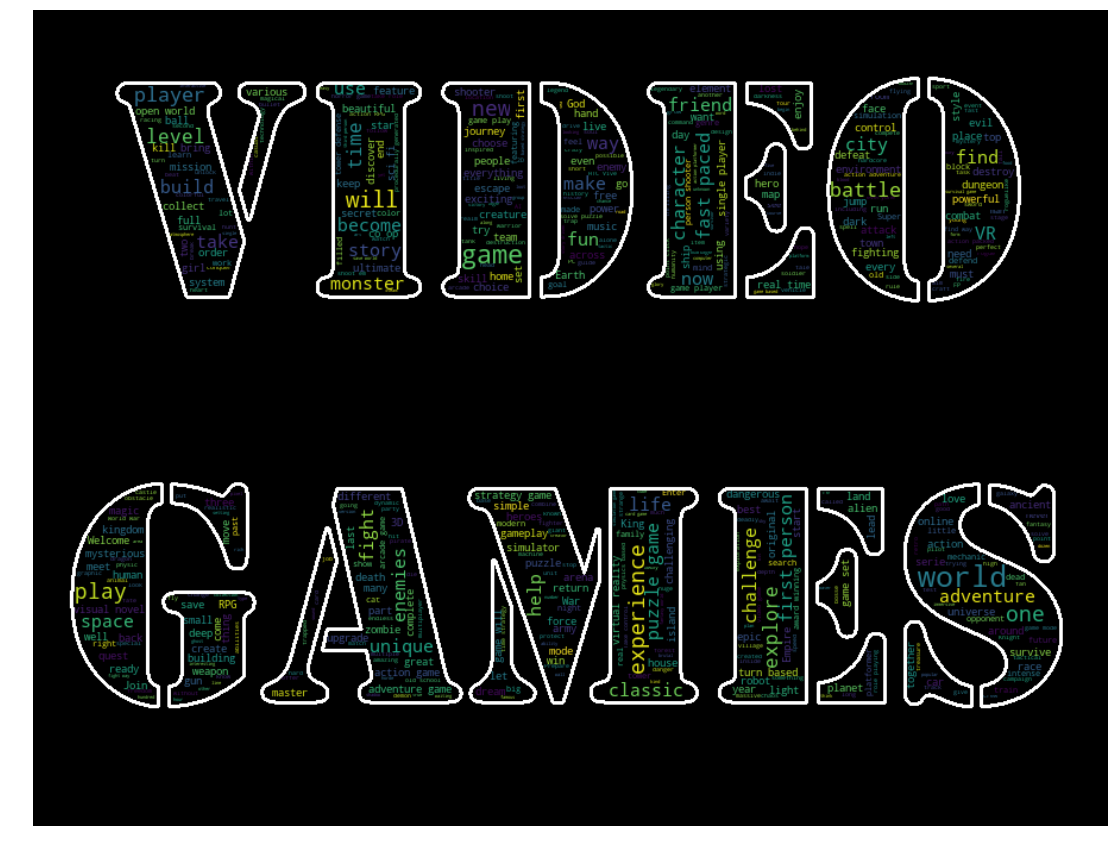

In [11]:
text = " ".join(desc for desc in df.description)
print ("There are {:,.0f} words in the combination of all descriptions.".format(len(text)))
stopwords = set(STOPWORDS)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
video_mask = np.array(Image.open(path.join(d, "video_game_mask.png")))
wc = WordCloud(stopwords=stopwords, background_color="black", max_words=10000,
                      contour_width=3, mask=video_mask, contour_color='white').generate(text)

wc.to_file(path.join(d, 'video_games.png'))

fig, ax = plt.subplots(figsize=(20, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

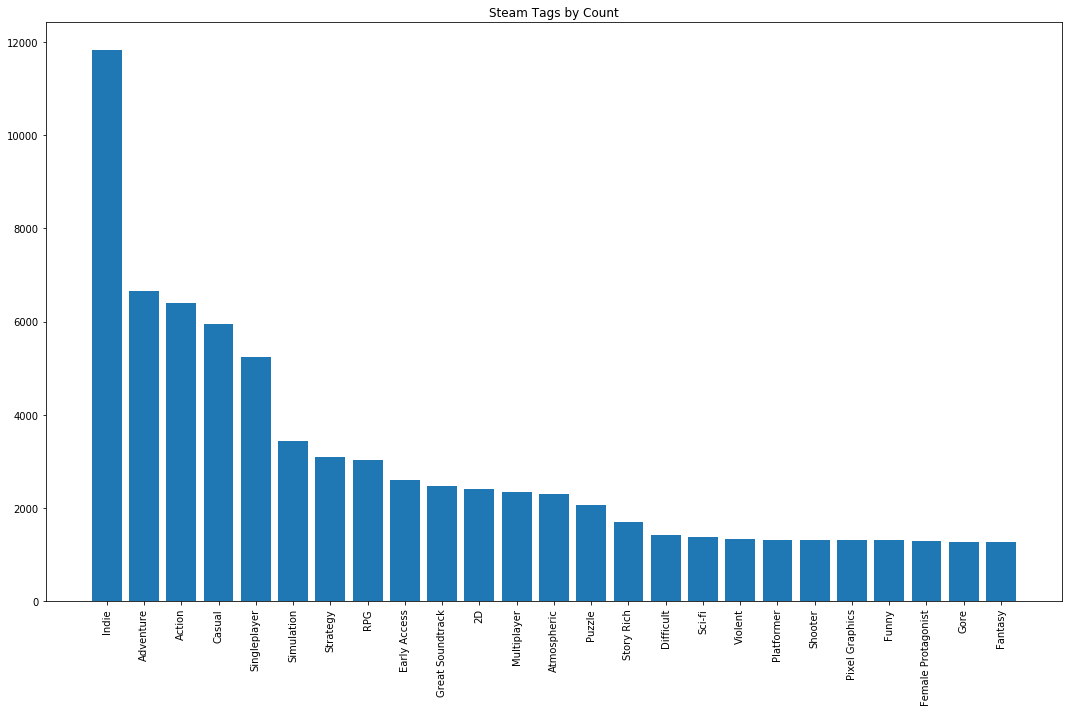

In [12]:
text = " ".join(desc for desc in df.tags)
textlist = text.split(", ")
wordfreq = [textlist.count(w) for w in textlist]
pairs = Counter(text.split(", ")).most_common(25)
word = []
frequency = []

for i in range(len(pairs)):
    word.append(pairs[i][0])
    frequency.append(pairs[i][1])

indices = np.arange(len(pairs))
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(indices, frequency)
plt.title('Steam Tags by Count')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

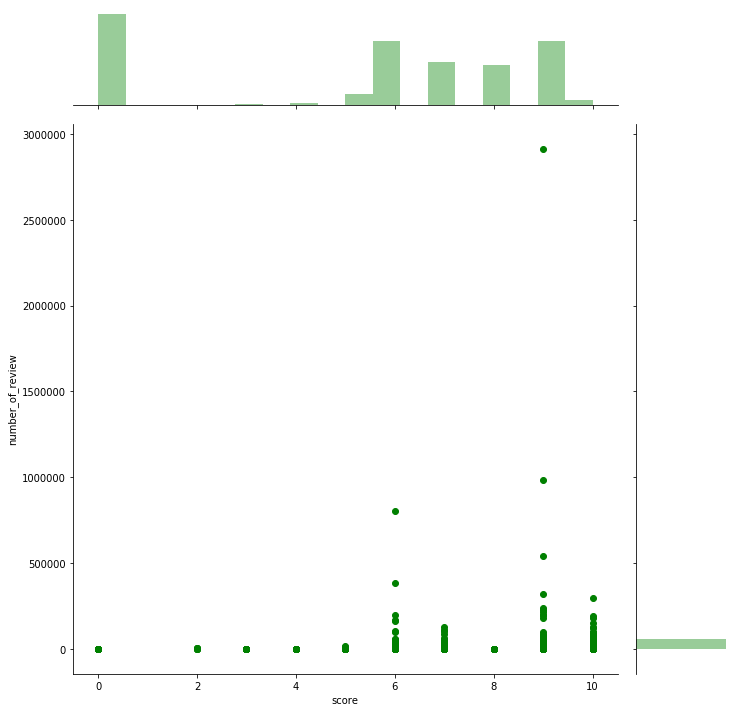

In [58]:

sns.jointplot(x='score', y='number_of_review', data=df, height=10, color='g')
#plt.title('Steam Tags by Count')
#plt.xticks(indices, word, rotation='vertical')
plt.show()

In [16]:
my_steam_id = 76561197974553664
games = interface('IPlayerService').GetOwnedGames(steamid=my_steam_id, include_appinfo=1)
my_games = games['response']['games']
game_table = pd.DataFrame(my_games)
game_table = game_table.drop(['has_community_visible_stats', 'playtime_2weeks',
                              'img_icon_url', 'img_logo_url'], axis=1)
my_games_info = pd.merge(df, game_table, on='appid')
not_my_games = pd.merge(df, game_table, how='outer', on='appid')
not_my_games = not_my_games[not_my_games['playtime_forever'].isnull()]
not_my_games = not_my_games.drop(['name', 'image', 'playtime_forever'], axis=1)
not_my_games.head()

,game_title,steam_url,tags,description,number_of_review,score,release_date,appid
1,MONSTER HUNTER: WORLD,https://store.steampowered.com/app/582010/MONSTER_HUNTER_WORLD/?snr=1_7_7_23...,"Action, Hunting, Co-op, Open World, Multiplayer, Third Person, RPG, Adventur...","Welcome to a new world! In Monster Hunter: World, the latest installment in ...","55,314.00000",6.00000,"Aug 9, 2018",582010
2,Path of Exile,https://store.steampowered.com/app/238960/Path_of_Exile/?snr=1_7_7_230_150_1,"Free to Play, Action RPG, Hack and Slash, RPG, Multiplayer, Massively Multip...","You are an Exile, struggling to survive on the dark continent of Wraeclast, ...","74,977.00000",9.00000,"Oct 23, 2013",238960
3,Insurgency: Sandstorm,https://store.steampowered.com/app/581320/Insurgency_Sandstorm/?snr=1_7_7_23...,"FPS, Realistic, Shooter, Multiplayer, Action, Military, Tactical, Singleplay...","Insurgency: Sandstorm is a team-based, tactical FPS based on lethal close qu...","9,019.00000",9.00000,"Dec 12, 2018",581320
4,Warframe,https://store.steampowered.com/app/230410/Warframe/?snr=1_7_7_230_150_1,"Free to Play, Action, Co-op, Multiplayer, Third-Person Shooter, Sci-fi, Ninj...",Warframe is a cooperative free-to-play third person online action game set i...,"236,593.00000",9.00000,"Mar 25, 2013",230410
5,Divinity: Original Sin 2 - Definitive Edition,https://store.steampowered.com/app/435150/Divinity_Original_Sin_2__Definitiv...,"RPG, Turn-Based, Co-op, Story Rich, Fantasy, Open World, Character Customiza...",The eagerly anticipated sequel to the award-winning RPG. Gather your party. ...,"37,446.00000",9.00000,"Sep 14, 2017",435150


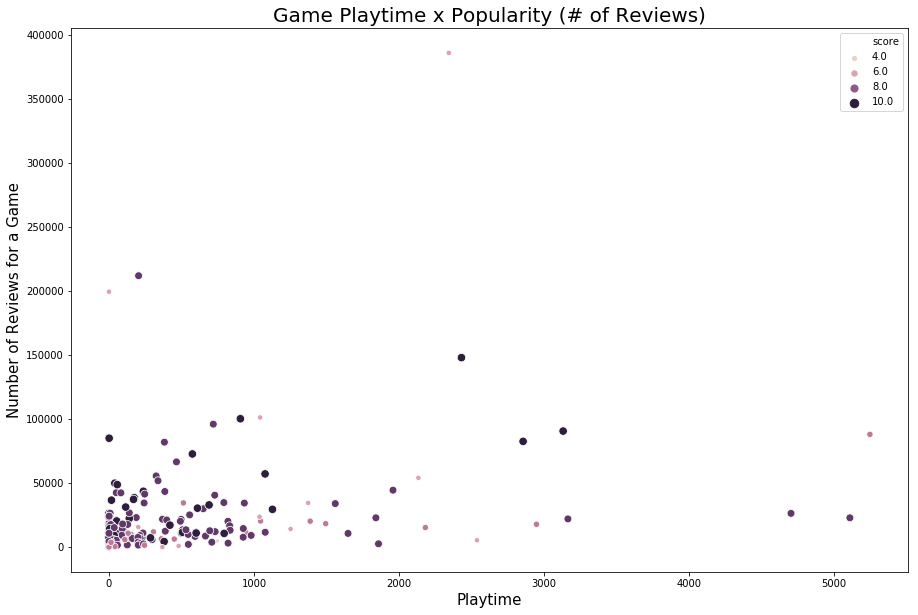

In [17]:
df_csno = my_games_info[~my_games_info.game_title.str.contains('Counter-Strike: Global Offensive')]
df_csno = df_csno[df_csno['playtime_forever'] <= 8000]

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.scatterplot(x="playtime_forever", y="number_of_review", hue="score", 
                     size= 'score', data=df_csno)
plt.title('Game Playtime x Popularity (# of Reviews)', size = 20)
plt.xlabel('Playtime', size=15)
plt.ylabel('Number of Reviews for a Game', size=15)
plt.show()

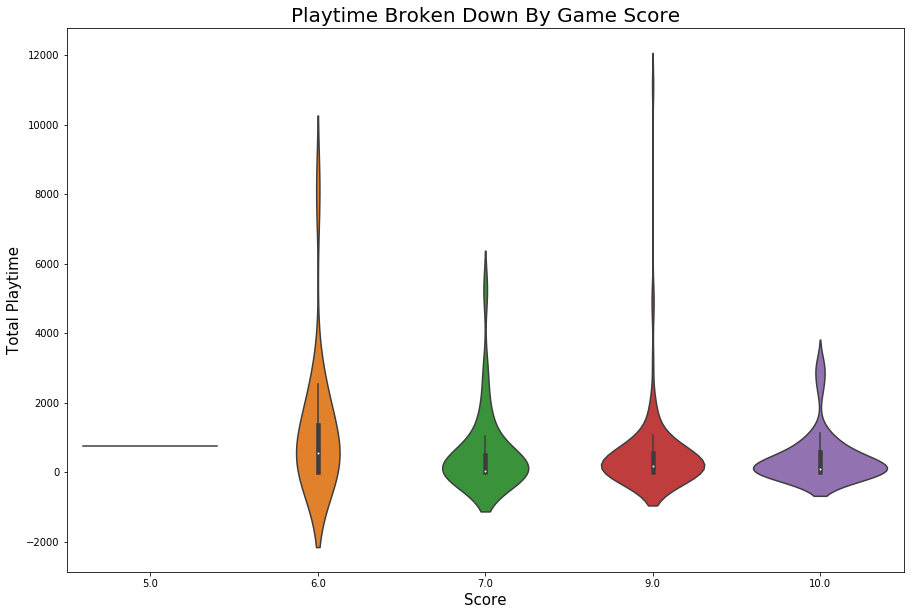

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(x="score", y="playtime_forever", data=my_games_info)
plt.title('Playtime Broken Down By Game Score', size = 20)
plt.xlabel('Score', size=15)
plt.ylabel('Total Playtime', size=15)
plt.show()

## Building the Recommender ##
### Tags Vs. Descriptions ###
For building the actual recommender system, I had originally decided that I would use Steam tags that are associated with every game.  However, because it was easy enough to collect, I also had descriptions for every game.  So I decided to test the recommendation system with three different setups.  The first being description only, the second being tags only, and the third being a hybrid of both.

In [23]:
tfidf_vec_desc = df[['appid', 'game_title', 'tags', 'description']]
tf = TfidfVectorizer(analyzer='word', lowercase=True, ngram_range=(0, 1), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(tfidf_vec_desc['description'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

results_desc = {}

for idx, row in tfidf_vec_desc.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], tfidf_vec_desc['appid'][i]) for i in similar_indices]
    results_desc[row['appid']] = similar_items[1:]
    
print('done!')

done!


In [56]:
tfidf_matrix[0]
#cosine_similarities
#heat = pd.DataFrame(cosine_similarities[0:10, :10])
#sns.heatmap(heat)

<1x34163 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [20]:
def recommend(game, num):
    app_id = tfidf_vec_desc.loc[tfidf_vec_desc['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_desc[app_id]
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 60]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

Recommending 5 games sitting in your Steam library unplayed, that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,playtime_forever
0,0.03715,Prince of Persia,0
1,0.02914,LIMBO,0
2,0.02678,Psychonauts,0
3,0.02520,Hellblade: Senua's Sacrifice VR Edition,0
4,0.02190,Hellblade: Senua's Sacrifice,27


In [24]:
def recommend(game, num):
    app_id = tfidf_vec_desc.loc[tfidf_vec_desc['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_desc[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description'], axis = 1)
    #my_game_df = my_game_df[my_game_df['playtime_forever'] <= 60]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

Fine, here are 5 games you could buy that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,steam_url
0,0.30626,Type:Rider,https://store.steampowered.com/app/258890/TypeRider/?snr=1_7_7_230_150_162
1,0.27387,Assassin’s Creed Rogue,https://store.steampowered.com/app/311560/Assassins_Creed_Rogue/?snr=1_7_7_2...
2,0.25681,Assassin's Creed Origins,https://store.steampowered.com/app/582160/Assassins_Creed_Origins/?snr=1_7_7...
3,0.24837,Odyssey VR - The Deep Space Expedition,https://store.steampowered.com/app/738600/Odyssey_VR__The_Deep_Space_Expedit...
4,0.24784,Fate Hunters,https://store.steampowered.com/app/920680/Fate_Hunters/?snr=1_7_7_230_150_155


In [37]:
count_vec_tags = df[['appid', 'game_title', 'tags', 'description']]
# Using CountVectorizer here instead of TFIDFVectorizer, since the latter
vectorizer = CountVectorizer(analyzer='word', lowercase=True)
count_matrix = vectorizer.fit_transform(count_vec_tags['tags'])
cosine_similarities = cosine_similarity(count_matrix, count_matrix)
results_tags = {}

for idx, row in count_vec_tags.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], count_vec_tags['appid'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results_tags[row['appid']] = similar_items[1:]
    


Recommending 5 games sitting in your Steam library unplayed, that are similar to Assassin's Creed Odyssey.


,sim_score,game_title,playtime_forever
10,0.55762,Mass Effect 2,35
12,0.54595,Prince of Persia,0
23,0.51320,Fallout 3: Game of the Year Edition,0
26,0.50918,Prince of Persia: Warrior Within,6
28,0.49892,Quantum Break,0


In [54]:
#count_matrix.toarray()
index = vectorizer.get_feature_names()

pd.DataFrame(cosine_similarities, columns=index)
#heat
#sns.heatmap(heat)
#for i in range(10):
 #   print(i,heat.index[i])

ValueError: Shape of passed values is (23601, 23601), indices imply (400, 23601)

In [ ]:
def recommend(game, num):
    app_id = count_vec_tags.loc[count_vec_tags['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 60]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

In [ ]:
df['tag_desc'] = df[['tags', 'description']].apply(lambda x: ' '.join(x), axis=1)
tfidf_vec_tag_desc = df[['index' ,'appid', 'game_title', 'tag_desc']]
tf = TfidfVectorizer(analyzer='word', lowercase=True, ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(tfidf_vec_tag_desc['tag_desc'])
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

results_tags_desc = {}

for idx, row in tfidf_vec_tag_desc.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-500:-1]
    similar_items = [(cosine_similarities[idx][i], tfidf_vec_tag_desc['appid'][i]) for i in similar_indices]

    # First item is the item itself, so remove it.
    # Each dictionary entry is like: [(1,2), (3,4)], with each tuple being (score, item_id)
    results_tags_desc[row['appid']] = similar_items[1:]
    
print('done!')



In [ ]:
def recommend(game, num):
    app_id = tfidf_vec_tag_desc.loc[tfidf_vec_tag_desc['game_title'] == game]['appid'].tolist()[0]
    
    print('Recommending ' + str(num) + " games sitting in your Steam library unplayed, that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, my_games_info, how='inner', on='appid')
    my_game_df = my_game_df.drop(['index', 'appid', 'number_of_review', 'release_date', 'name', 'score',
                                  'tags', 'description', 'steam_url', 'image'], axis = 1)
    my_game_df = my_game_df[my_game_df['playtime_forever'] <= 60]
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)

In [ ]:
def recommend(game, num):
    app_id = tfidf_vec_tag_desc.loc[tfidf_vec_tag_desc['game_title'] == game]['appid'].tolist()[0]
    
    print('Fine, here are ' + str(num) + " games you could buy that are similar to " + 
          game + '.')

    rez = results_tags_desc[app_id]
    #print(rez)
    sim_score_df = pd.DataFrame(rez, columns=['sim_score', 'appid'])
    #print(df_test)
    my_game_df = pd.merge(sim_score_df, not_my_games, how='inner', on='appid')
    my_game_df = my_game_df.drop(['index', 'appid', 'number_of_review', 'release_date', 'score',
                                  'tags', 'description', 'tag_desc'], axis = 1)
    my_game_df = my_game_df.sort_values(['sim_score'], ascending=False)
    return my_game_df.head(num)

recommend("Assassin's Creed Odyssey", 5)